## Tensorflow-model

In [141]:
# Import packages for tensorflow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import metrics

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [142]:
var_set = pd.read_csv('var_set.csv', parse_dates=[0],index_col=[0])

In [143]:
var_set['month'] = pd.DatetimeIndex(var_set.index).month

In [144]:
var_set

,SalmonPrice,CodPrice,HalibutPrice,CPI,TWI,month
2013-04-07,39.63,10.754267,47.577612,95.55,92.1500,4
2013-04-14,41.89,10.800751,47.924958,95.70,92.1920,4
2013-04-21,43.07,10.774089,47.092639,95.85,92.7980,4
2013-04-28,42.70,10.569605,47.193296,96.00,93.8080,4
2013-05-05,41.81,10.605343,48.987917,96.02,93.3125,5
...,...,...,...,...,...,...
2022-11-20,82.49,39.417280,76.897925,128.50,122.2180,11
2022-11-27,79.03,39.071706,73.642666,128.40,122.0320,11
2022-12-04,78.05,42.701713,73.193629,128.70,120.8780,12
2022-12-11,75.83,43.652968,74.156841,129.00,122.7060,12


In [145]:
X = var_set.drop(columns=["SalmonPrice"], axis = 1)
y = var_set["SalmonPrice"]

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 50, shuffle=False)

In [147]:
x_uni = var_set["SalmonPrice"]

In [148]:
x_uni_train,y_uni_test = train_test_split(x_uni, test_size = 50, shuffle=False)

In [149]:
len(X_train)

457

In [150]:
# Scale x and y multivariate
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Scale y
scaler = MinMaxScaler()
y_train = scaler.fit_transform(y_train.values.reshape(-1,1))
y_test = scaler.transform(y_test.values.reshape(-1,1))

In [151]:
# Scale x and y multivariate
scaler = MinMaxScaler()
x_uni_train = scaler.fit_transform(x_uni_train.values.reshape(-1,1))
y_uni_test = scaler.transform(y_uni_test.values.reshape(-1,1))

In [152]:

scaler = MinMaxScaler()
x_minmax_train = scaler.fit_transform(x_uni_train)
y_minmax_test = scaler.transform(y_uni_test)

In [135]:
generated_batches = TimeseriesGenerator(x_minmax_train, x_minmax_train, length=52, batch_size=1)

In [136]:
len(generated_batches)

405

Epoch 1/50


/var/folders/xy/_0zst1c12b9_m_438bw49zw40000gn/T/ipykernel_78548/3455660599.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generated_batches,epochs=50)
2023-04-22 18:49:04.498780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


405/405 [==============================] - 2s 5ms/step - loss: 0.0635
Epoch 2/50
405/405 [==============================] - 2s 5ms/step - loss: 0.0384
Epoch 3/50
405/405 [==============================] - 2s 5ms/step - loss: 0.0288
Epoch 4/50
405/405 [==============================] - 2s 5ms/step - loss: 0.0251
Epoch 5/50
405/405 [==============================] - 2s 5ms/step - loss: 0.0220
Epoch 6/50
405/405 [==============================] - 2s 5ms/step - loss: 0.0202
Epoch 7/50
405/405 [==============================] - 2s 5ms/step - loss: 0.0191
Epoch 8/50
405/405 [==============================] - 2s 5ms/step - loss: 0.0178
Epoch 9/50
405/405 [==============================] - 2s 5ms/step - loss: 0.0170
Epoch 10/50
405/405 [==============================] - 2s 5ms/step - loss: 0.0151
Epoch 11/50
405/405 [==============================] - 2s 5ms/step - loss: 0.0146
Epoch 12/50
405/405 [==============================] - 2s 5ms/step - loss: 0.0140
Epoch 13/50
405/405 [===============

2023-04-22 18:50:39.346853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 10ms/step
Test RMSE: 3.051


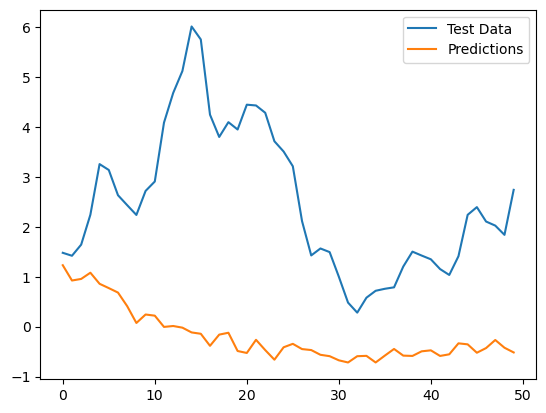

In [137]:
# Create the model
model = Sequential()
model.add(Flatten(input_shape=(52,1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Fit the model
model.fit_generator(generated_batches,epochs=50)

# Make predictions
test_predictions = []

first_eval_batch = x_minmax_train[-52:]
current_batch = first_eval_batch.reshape((1, 52, 1))

for i in range(len(y_minmax_test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

true_predictions = scaler.inverse_transform(test_predictions)

# Plot the predictions
test_predictions = pd.Series(true_predictions.reshape(50,))
y_uni_test = pd.Series(y_uni_test.reshape(50,))
plt.plot(y_uni_test, label='Test Data')
plt.plot(test_predictions, label='Predictions')
plt.legend()

# Evaluate the model
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(y_uni_test, test_predictions))
print('Test RMSE: %.3f' % rmse)